# Dataset generation and exploratory data analysis

In [1]:
# add parent dir to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from pathlib import Path
from params import PATH_DATA, PATH_OUT

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from fastprogress.fastprogress import progress_bar

import matplotlib.image as mpimg

from tools import csv2ndarray, get_label
import hashlib

## 1. Labels distribution
Labels are enoded in filename. It is the word after the last underscore, before the dot.

In [2]:
fnames = list(PATH_DATA.rglob("*.csv"))

def get_label(fname):
    return fname.name.split('.')[0].split('_')[-1]

labels = [get_label(fname) for fname in fnames]
c = Counter(labels)
c

Counter({'OK': 4676, 'empty': 3815, 'WARNING': 1119})

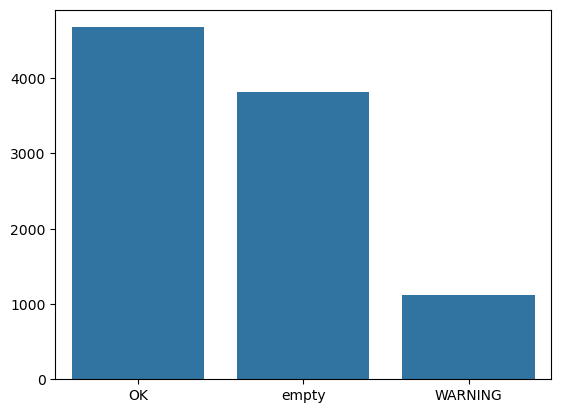

In [3]:
# plot the distribution of the labels
sns.barplot(x=list(c.keys()), y=list(c.values()));

We see that we have three classes: `OK`, `empty` and `WARNING`, classes are not balanced.

## 2. Extract arrays from the `.csv` files and save them to `.npy` format

In [5]:
path_data_npy = PATH_OUT / "data_npy"
path_data_npy.mkdir(exist_ok=True, parents=True)

In [6]:
for fname in progress_bar(list(PATH_DATA.rglob("*.csv"))):
    name = fname.name
    parent = fname.parent.name
    # crate a parent dir if it doesn't exist
    (path_data_npy / parent).mkdir(exist_ok=True)
    df = pd.read_csv(fname, index_col=0)
    values = df.values
    # fill NA values with 0
    values = np.nan_to_num(values)
    np.save(path_data_npy / parent / f"{name[:-4]}.npy", values)

## 3. Explore duplicates per experiments group
Each experiments group (`COMBO-11`, ..., `CTF-P019`) may contain the same plates, but with different labels, encoded in their names. Let's find out those duplicates.

In [7]:
# check if `data_hashes.csv` exists and load if so
if (PATH_OUT / "data_hashes.csv").exists():
    df_hashes = pd.read_csv(PATH_OUT / "data_hashes.csv", index_col=0)
else:
    df_hashes = pd.DataFrame(columns=["experiment_group", "fname", "name", "label", "hash"])
    fnames = list(path_data_npy.rglob("*.npy"))
    for idx, fname in progress_bar(enumerate(fnames), total=len(fnames)):
        name = fname.name
        parent = fname.parent.name
        values = np.load(fname)
        hash = hashlib.md5(str(values).encode()).hexdigest()
        df_hashes.loc[idx] = [parent, fname, name, get_label(fname), hash]
    
    df_hashes.to_csv(PATH_OUT / "data_hashes.csv")

In [8]:
df_hashes

,experiment_group,fname,name,label,hash
0,CTF-P007,../out/data_npy/CTF-P007/plate_17305eb6f8d7_OK...,plate_17305eb6f8d7_OK.npy,OK,2aad337f0fac9e7a3b2b640d0f6c7a04
1,CTF-P007,../out/data_npy/CTF-P007/plate_1730d1b301_OK.npy,plate_1730d1b301_OK.npy,OK,b1e922e435b537a29f56a3bf2e8c8270
2,CTF-P007,../out/data_npy/CTF-P007/plate_173028eaef6f_OK...,plate_173028eaef6f_OK.npy,OK,65c9988aa9fa604541ef25873fda2b32
3,CTF-P007,../out/data_npy/CTF-P007/plate_17305a2c7b5a_WA...,plate_17305a2c7b5a_WARNING.npy,WARNING,d5b9318dade81b4802799f35a67bfce0
4,CTF-P007,../out/data_npy/CTF-P007/plate_1730739b905b_OK...,plate_1730739b905b_OK.npy,OK,14cb73ead9df0e122b36f830bb7e6a5b
...,...,...,...,...,...
9605,CTF-P010,../out/data_npy/CTF-P010/plate_1730752ca902_OK...,plate_1730752ca902_OK.npy,OK,961dfe4c249eacd4ffd0b2841e9d0b00
9606,CTF-P010,../out/data_npy/CTF-P010/plate_17306c6618b0_em...,plate_17306c6618b0_empty.npy,empty,c9b571714aba2fa4758ca6078122be6a
9607,CTF-P010,../out/data_npy/CTF-P010/plate_173020416f9_emp...,plate_173020416f9_empty.npy,empty,ceed04d57b849b59007cdefdaeec8b76
9608,CTF-P010,../out/data_npy/CTF-P010/plate_17305cdea61f_em...,plate_17305cdea61f_empty.npy,empty,062d4049317a8b32bad700628a09effa


In [10]:
df_hashes.fname.unique().shape

(9610,)

We have `9610` plates, but do we have any duplicates?

In [11]:
df_hashes.hash.unique().shape

(3372,)

So, we have only `3372` unique plates.<br>What is the distribution of labels among the files with identical hashes?

In [12]:
df_hashes.hash.value_counts()

hash
3837731e6d328ae032cd380c08cc7cce    70
40b908203ff65f28255436809565d903    26
2983a0ecc9e36a773a05e12d4a83f057    26
344d461bcc2cf6a8b425ba1b574a4bc2    21
0ff9e20ecd5a3b4d41198604ce9e58ad    21
                                    ..
ed7500c0715cf92e21bfeb687469b58f     1
a9341e45223abcd81a9d82cf3ec235ab     1
e61add6a9c517aaa3c55037a29421bb3     1
d8fa1b29f0fae63ca95037d5f38defea     1
634a22af5e1b55a990b6b94e3da84248     1
Name: count, Length: 3372, dtype: int64

In [13]:
# get index of pandas series where value is True
hashes_duplicates = df_hashes.hash.value_counts().index[df_hashes.hash.value_counts() > 1].to_list()
print(f"len(hashes_duplicates): {len(hashes_duplicates)}")
hashes_duplicates[:5]

len(hashes_duplicates): 2606


['3837731e6d328ae032cd380c08cc7cce',
 '40b908203ff65f28255436809565d903',
 '2983a0ecc9e36a773a05e12d4a83f057',
 '344d461bcc2cf6a8b425ba1b574a4bc2',
 '0ff9e20ecd5a3b4d41198604ce9e58ad']

In [14]:
hashes_no_duplicates = df_hashes.hash.value_counts().index[df_hashes.hash.value_counts() == 1].to_list()
print(f"len(hashes_no_duplicates): {len(hashes_no_duplicates)}")
hashes_no_duplicates[:5]

len(hashes_no_duplicates): 766


['6a4cc267a0791293619075463555ba15',
 '0feb1ae8ed7e155dc750794c63b8782a',
 'dc14b7014a3a2b1a77e1ab8ed85fd331',
 'c7363717d0ef3ff1179d51ee6a981233',
 '0b1cb501c19bf587a14029367ced5b2c']

Labels distribution per hash:

In [15]:
# check if `data_hashes_duplicates.csv` exists and load if so
if (PATH_OUT / "data_hashes_duplicates.csv").exists():
    df_hashes_dup = pd.read_csv(PATH_OUT / "data_hashes_duplicates.csv")
else:
    df_hashes_dup = pd.DataFrame(columns=["hash", "OK", "empty", "WARNING"])

    for idx, hash in progress_bar(enumerate(hashes_duplicates), total=len(hashes_duplicates)):
        # select all rows with the same hash
        df = df_hashes[df_hashes.hash == hash]
        d = df.label.value_counts().to_dict()
        keys = ["OK", "empty", "WARNING"]
        for key in keys:
            if key not in d:
                d[key] = 0
        df_hashes_dup.loc[idx] = [hash] + list(d.values())

    df_hashes_dup.to_csv(PATH_OUT / "data_hashes_duplicates.csv")

In [16]:
df_hashes_dup

,hash,OK,empty,WARNING
0,3837731e6d328ae032cd380c08cc7cce,70,0,0
1,40b908203ff65f28255436809565d903,20,6,0
2,2983a0ecc9e36a773a05e12d4a83f057,20,6,0
3,344d461bcc2cf6a8b425ba1b574a4bc2,14,7,0
4,0ff9e20ecd5a3b4d41198604ce9e58ad,14,7,0
...,...,...,...,...
2601,36440c720951e6b0796fb97c4655f1c8,2,0,0
2602,e476450941452d92a8b9cb9a688dcb49,2,0,0
2603,6efb3d9495532fb69a8fea3e6442febb,2,0,0
2604,272f3a2ea8200b1d97b6a9331a08ac9b,1,1,0


How many of hashes has only one unique label?

In [18]:
def only_one_label(row):
    if not 0 in row.value_counts():
        return False
    if row.value_counts()[0] == 2:
        return True
    return False


In [23]:
only_one_label_count = 0
# iterate over all rows in df_hashes_dup
for idx, row in progress_bar(df_hashes_dup.iterrows(), total=len(df_hashes_dup)):
    if only_one_label(row):
        only_one_label_count += 1
print(f"only_one_label_count: {only_one_label_count}")

only_one_label_count: 711


In [26]:
df_hashes_dup.shape

(2606, 4)

So, we have `711` hashes without conflicting labels. What is the distribution of labels in the rest of `2606` - `711` = `1895` cases?

In [27]:
def more_than_one_label(row):
    return not only_one_label(row)

# select all rows which have more than one label
df_hashes_dup_more_than_one_label = df_hashes_dup[df_hashes_dup.apply(more_than_one_label, axis=1)]
df_hashes_dup_more_than_one_label.shape

(1895, 4)

In [28]:
df_hashes_dup_more_than_one_label

,hash,OK,empty,WARNING
1,40b908203ff65f28255436809565d903,20,6,0
2,2983a0ecc9e36a773a05e12d4a83f057,20,6,0
3,344d461bcc2cf6a8b425ba1b574a4bc2,14,7,0
4,0ff9e20ecd5a3b4d41198604ce9e58ad,14,7,0
5,af228898c7c84ed9ac2eabe9d167a128,14,7,0
...,...,...,...,...
2576,29fc4d7d134b7871d5c08dc4c1842a80,1,1,0
2591,5046af52a678cbc82f68c0e641900117,1,1,0
2594,95dd0bcea896ab68db4158bfb1323f96,1,1,0
2595,13a31b9bdaa1530ede662729290f6168,1,1,0


Extract unique plates with well-defined labels. It means unique plates or plates that have duplicates but all of those duplicates have the same label:

In [38]:
# hashes of all plates that have duplicates, but only one label
hashes_dup_unique_label_lst = df_hashes_dup[df_hashes_dup.apply(only_one_label, axis=1)].hash.to_list()

In [40]:
hashes_reliable_labels = hashes_no_duplicates + hashes_dup_unique_label_lst
print(f"len(hashes_reliable_labels): {len(hashes_reliable_labels)}")

len(hashes_reliable_labels): 1477


Get the dataframe with plates which have only reliable labels:

In [41]:
df_hashes_reliable_labels = df_hashes[df_hashes.hash.isin(hashes_reliable_labels)]
df_hashes_reliable_labels

,experiment_group,fname,name,label,hash
0,CTF-P007,../out/data_npy/CTF-P007/plate_17305eb6f8d7_OK...,plate_17305eb6f8d7_OK.npy,OK,2aad337f0fac9e7a3b2b640d0f6c7a04
1,CTF-P007,../out/data_npy/CTF-P007/plate_1730d1b301_OK.npy,plate_1730d1b301_OK.npy,OK,b1e922e435b537a29f56a3bf2e8c8270
9,CTF-P007,../out/data_npy/CTF-P007/plate_17301dc7efec_OK...,plate_17301dc7efec_OK.npy,OK,c1706ac7244c1b825b8f4a895393e8de
11,CTF-P007,../out/data_npy/CTF-P007/plate_17306b2164df_OK...,plate_17306b2164df_OK.npy,OK,b6ab9185bb53614f8b55f5976cf1b22a
18,CTF-P007,../out/data_npy/CTF-P007/plate_17304a596439_OK...,plate_17304a596439_OK.npy,OK,c9285ac25716323da1c3429f39de1231
...,...,...,...,...,...
9604,CTF-P010,../out/data_npy/CTF-P010/plate_17305fc91da7_em...,plate_17305fc91da7_empty.npy,empty,b60efb3c8fbb817b10e434a7c9dcb6dd
9605,CTF-P010,../out/data_npy/CTF-P010/plate_1730752ca902_OK...,plate_1730752ca902_OK.npy,OK,961dfe4c249eacd4ffd0b2841e9d0b00
9607,CTF-P010,../out/data_npy/CTF-P010/plate_173020416f9_emp...,plate_173020416f9_empty.npy,empty,ceed04d57b849b59007cdefdaeec8b76
9608,CTF-P010,../out/data_npy/CTF-P010/plate_17305cdea61f_em...,plate_17305cdea61f_empty.npy,empty,062d4049317a8b32bad700628a09effa


In [44]:
# remove duplicate rows
df_hashes_reliable_labels = df_hashes_reliable_labels.drop_duplicates(subset=["hash"], keep="first")
df_hashes_reliable_labels.shape

(1477, 5)

In [46]:
# save to the out folder
df_hashes_reliable_labels.to_csv(PATH_OUT / "data_hashes_reliable_labels.csv")

Actual distribution of the labels of plates, ignoring plates with conflicting labels:

In [50]:
df_hashes_reliable_labels

,experiment_group,fname,name,label,hash
0,CTF-P007,../out/data_npy/CTF-P007/plate_17305eb6f8d7_OK...,plate_17305eb6f8d7_OK.npy,OK,2aad337f0fac9e7a3b2b640d0f6c7a04
1,CTF-P007,../out/data_npy/CTF-P007/plate_1730d1b301_OK.npy,plate_1730d1b301_OK.npy,OK,b1e922e435b537a29f56a3bf2e8c8270
9,CTF-P007,../out/data_npy/CTF-P007/plate_17301dc7efec_OK...,plate_17301dc7efec_OK.npy,OK,c1706ac7244c1b825b8f4a895393e8de
11,CTF-P007,../out/data_npy/CTF-P007/plate_17306b2164df_OK...,plate_17306b2164df_OK.npy,OK,b6ab9185bb53614f8b55f5976cf1b22a
18,CTF-P007,../out/data_npy/CTF-P007/plate_17304a596439_OK...,plate_17304a596439_OK.npy,OK,c9285ac25716323da1c3429f39de1231
...,...,...,...,...,...
9604,CTF-P010,../out/data_npy/CTF-P010/plate_17305fc91da7_em...,plate_17305fc91da7_empty.npy,empty,b60efb3c8fbb817b10e434a7c9dcb6dd
9605,CTF-P010,../out/data_npy/CTF-P010/plate_1730752ca902_OK...,plate_1730752ca902_OK.npy,OK,961dfe4c249eacd4ffd0b2841e9d0b00
9607,CTF-P010,../out/data_npy/CTF-P010/plate_173020416f9_emp...,plate_173020416f9_empty.npy,empty,ceed04d57b849b59007cdefdaeec8b76
9608,CTF-P010,../out/data_npy/CTF-P010/plate_17305cdea61f_em...,plate_17305cdea61f_empty.npy,empty,062d4049317a8b32bad700628a09effa


In [52]:
c = Counter(df_hashes_reliable_labels.label)
c

Counter({'OK': 1054, 'empty': 222, 'WARNING': 201})

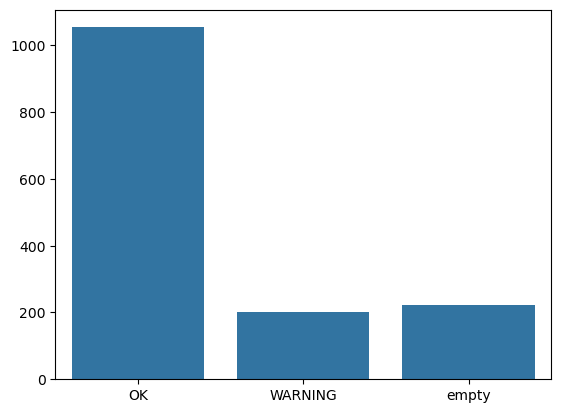

In [53]:
sns.barplot(x=list(c.keys()), y=list(c.values()));

## Explore shapes distribution of images

In [ ]:
shapes = []
for fname in progress_bar(os.listdir(path_data_npy)):
    name = fname.split('.')[0]
    values = np.load(path_data_npy / fname)
    shapes.append(values.shape)

In [ ]:
areas = [shape[0] * shape[1] for shape in shapes]
sns.histplot(areas, kde=True, bins=50);

## Select entries with the most common shape
So we see there is a subgroup of a large images. Let's select those as a candidates for our POC.

In [ ]:
c = Counter(areas)
most_common_areas = c.most_common(5)

In [ ]:
most_common_areas

So, we have `749` of arrays with area value `384`. Select `.npy` files that has an area `384`:

In [ ]:
MOST_COMMON_AREA = most_common_areas[0][0]
fnames_most_common_areas = []
shapes_most_common_areas = []
for fname in progress_bar(os.listdir(path_data_npy)):
    name = fname.split('.')[0]
    values = np.load(path_data_npy / fname)
    area = values.shape[0] * values.shape[1]
    if area == MOST_COMMON_AREA:
        fnames_most_common_areas.append(name)
        shapes_most_common_areas.append(values.shape)

In [ ]:
assert len(fnames_most_common_areas) == most_common_areas[0][1]

In [ ]:
Counter(shapes_most_common_areas)

They have the same shape, so no shape adjustment is needed. What about labels distribution?

In [ ]:
labels_most_common = [get_label(Path(fname)) for fname in fnames_most_common_areas]

In [ ]:
c = Counter(labels_most_common)
sns.barplot(x=list(c.keys()), y=list(c.values()));

In [ ]:
Counter(labels_most_common)

In [ ]:
# save the most common area filenames to text file
with open(PATH_OUT / 'fnames_most_common_areas.txt', 'w') as f:
    for item in fnames_most_common_areas:
        f.write("%s.npy\n" % item)

Copy this selected subset to the new folder:

In [ ]:
path_to = PATH_OUT / "data_classifier/"
path_to.mkdir(exist_ok=True)
for fname in progress_bar(fnames_most_common_areas):
    npy = np.load(path_data_npy / f"{fname}.npy")
    np.save(path_to / f"{fname}.npy", npy)

Extra step - convert `.npy` files to `.png` format:

In [ ]:
path_npy = PATH_OUT / "data_classifier"
path_png = PATH_OUT / "data_classifier_png"
path_png.mkdir(exist_ok=True)

In [ ]:
# iterate over all files in the path_npy folder
for fname in progress_bar(os.listdir(path_npy)):
    name = fname.split('.')[0]
    npy = np.load(path_npy / fname)
    mpimg.imsave(path_png / f"{name}.png", npy)

Plot example of generated images:

In [ ]:
# randomly select the file in the path_png folder
import random
import matplotlib.pyplot as plt

# load the selected file
p = path_png / random.choice(os.listdir(path_png))

# display the selected file
print(p)
plt.imshow(mpimg.imread(p));

Upscale images to `224 x 224`:

In [ ]:
# read .png file to numpy array
from PIL import Image

im = Image.open(p)
im = np.array(im)
im.shape

The fourth channel contains only `255` values.

In [ ]:
np.unique(im[:, :,3])

In [ ]:
import cv2

img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
res = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

In [ ]:
plt.imshow(res);

In [ ]:
img.shape